<a href="https://colab.research.google.com/github/Roseyshi/Wine-Quality-Classification/blob/main/Wine_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WINE QUALITY PREDICTION**
**BUSINESS PROBLEM**


**BUSINESS OBJECTIVE**


**DATA UNDERSTANDING**


In [26]:
#Importing libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load and read the dataset
data = pd.read_csv("/content/winequalityN.csv")
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.shape

(6497, 13)

### **Data Overview**
This section determines:


1.   Data Consistency
2.   Data Uniformity
3.   Data completeness






**Data Consistency**

In [5]:
#Check for duplicates
data.duplicated().sum()

1168

There are 1168 duplicates in the data. These will be dropped to ensure that the model is not bias based on the duplicates.

**Data Uniformity**

In [6]:
#Check for the data types of the columns
data.dtypes

,0
type,object
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64


Columns have the correct types. Feature engineering will not be done.

**Data Completeness**

In [7]:
data.isnull().sum()

,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


There are several columns with null rows, they do have much impact on the project since they are few. They will be dropped.

### **Data Cleaning**

Thsi will encompass:


1.   Dropping duplicated rows.
2.   Dropping null values.
3.   Dropping unnecessary columns.



In [8]:
#Drop duplicated rows
data.drop_duplicates(inplace = True)

In [9]:
#Drop null entries
data.dropna(inplace= True)

In [10]:
#Drop unnecessary columns
data.drop(columns = ['type'], axis = 1, inplace = True)

## **Exploratory Data Analysis**

The goal of this is to provide a visual explanation of the data.

**Distribution of target column**

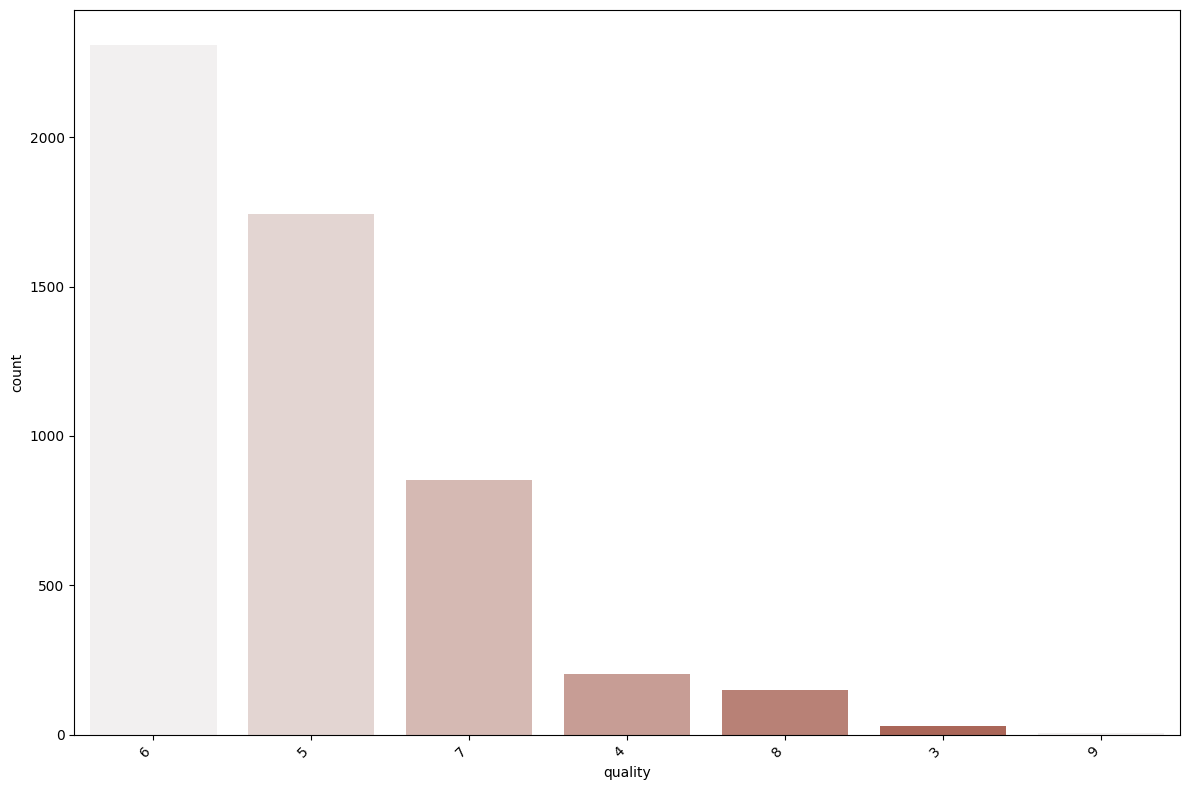

In [11]:
# Calculate the order of categories based on their size
sorted_categories = data['quality'].value_counts().index

# Plot the count plot
color = sns.light_palette((20, 60, 50), input="husl")
plt.figure(figsize=(12, 8))
sns.countplot(
    x='quality',
    data=data,
    palette=color,
    order=sorted_categories  # Align bars by size
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Quality 6 has more entries followed by 5, 7, 4, 8, 3, 9. Thsi shows data imbalance which will need to be taken care of using SMOTE technique.

**Relationship between alcohol and quality**

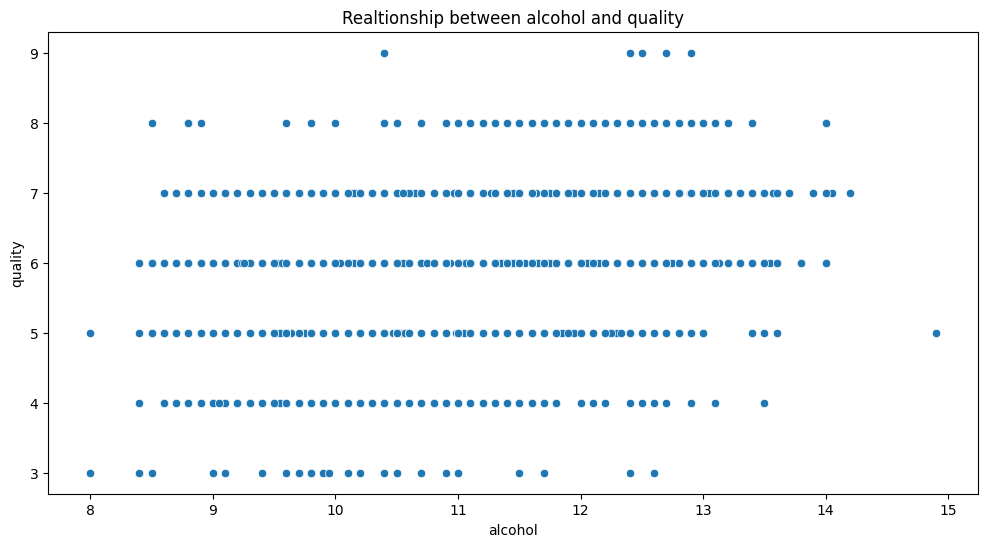

In [12]:
plt.figure(figsize = (12,6))
sns.scatterplot(data = data, x = 'alcohol', y = 'quality')
plt.title("Realtionship between alcohol and quality")
plt.show()

There is no particular correlation between alcohol and quality.

**Relationship of total sulfur dioxide and free sulfur dioxide on quality**

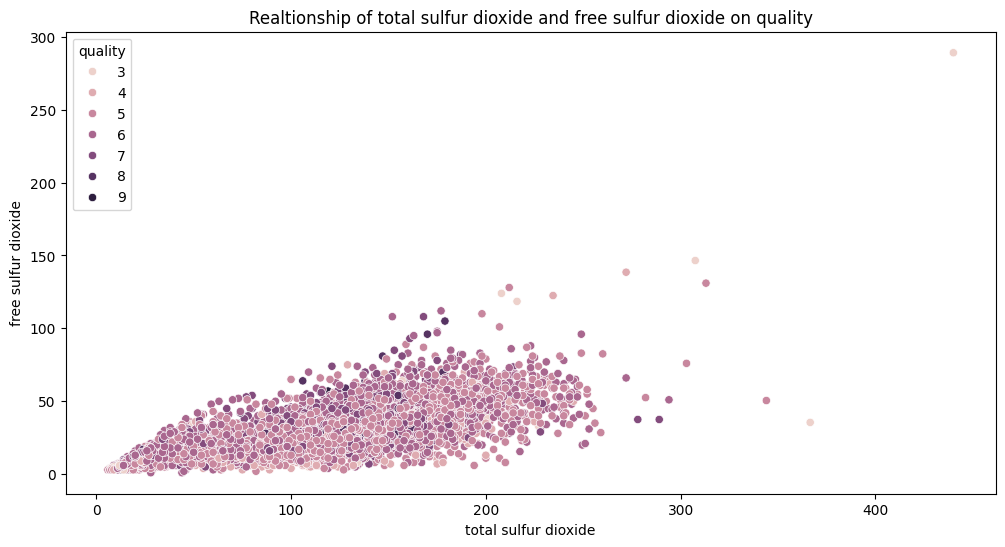

In [13]:
plt.figure(figsize = (12,6))
sns.scatterplot(data = data, x = 'total sulfur dioxide', y = 'free sulfur dioxide', hue = 'quality')
plt.title("Realtionship of total sulfur dioxide and free sulfur dioxide on quality")
plt.show()

Larger amounts of total sulfur dioxide have a greater effect on the quality of the wine as compared to same quantities of free sulfur dioxide.

**Correlation**

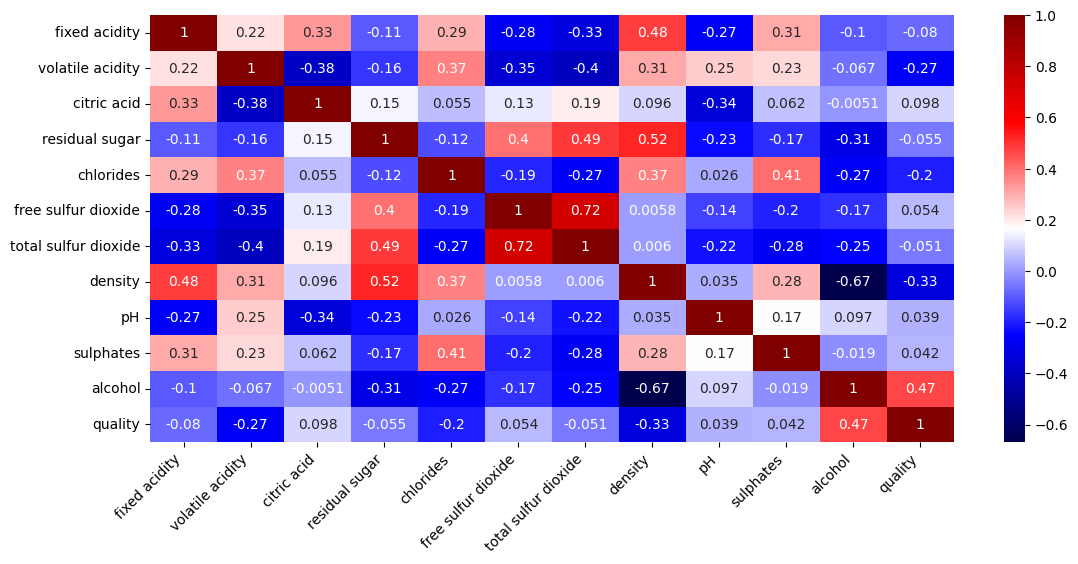

In [14]:
#Create a correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    data.corr(),
    annot=True,
    cmap='seismic',
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=2)
plt.show()

We will be on the look out for columns that seem to have correlation. These will have an effect on the model by virtue of multicorrelation. Density and alcohol seem to be columns with a high multicorrelation of 0.67 and therefore further analysis will be done on how they afftect the quality of the wine.

### **Feature Engineering**

In this case feature engineering will apply on the imbalance noticd earlier. SMOTE technique will be used in thsi case.

**Split the data into feature and target columns.**

In [22]:
#Drop quality column which is the target column and assign it to y
X = data.drop(columns = ['quality'], axis = 1)
y = data['quality']

**Standard Scaling**

StandardScaler operates on the principle of normalization, where it transforms the distribution of each feature to have a mean of zero and a standard deviation of one. This process ensures that all features are on the same scale, preventing any single feature from dominating the learning process due to its larger magnitude.

**Impact on Data Distribution:**
StandardScaler does not alter the shape of the distribution of each feature; it only shifts and scales it. As a result, the relative relationships between feature values are preserved, making it suitable for datasets with non-Gaussian distributions.

**Advantages:**
1. Enhances Model Performance: StandardScaler helps improve the performance and convergence of machine learning models, particularly those sensitive to feature scales, such as linear regression, logistic regression, and support vector machines.
2. Facilitates Interpretability: By standardizing features, StandardScaler makes it easier to interpret the coefficients or weights assigned to each feature in linear models.
3. Robustness to Outliers: StandardScaler is relatively robust to the presence of outliers compared to min-max scaling, as it relies on the mean and standard deviation rather than the range of the data.
Considerations:
4. Data Leakage: It's crucial to fit StandardScaler only on the training data and then apply the same transformation to the testing data to avoid data leakage and ensure model generalization.

In [16]:
#Initialize standard scaler
scaler = StandardScaler()

#Fit and transform on X
X_scaled = scaler.fit_transform(X)

**SMOTE**

Synthetic Minority Oversampling Technique, is a sampling technique that generates synthetic examples of the minority class in a dataset to balance the class distribution. It's commonly used when the class being analyzed is underrepresented.

In [25]:
# Compute the number of samples in the smallest class
minority_class_count = min(pd.Series(y).value_counts())
k_neighbors = min(5, minority_class_count - 1)  # Adjust k_neighbors accordingly

#Initialize smote with parameters
smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

#Determine the nummbers
print("Class distribution after SMOTE: \n", y_balanced.value_counts())

Class distribution after SMOTE: 
 quality
6    2311
5    2311
7    2311
8    2311
4    2311
3    2311
9    2311
Name: count, dtype: int64


**Split the data into train and test**

In [21]:
#Split the scaled data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size = 0.3, random_state = 42)

### **Model Selection**

The project is a classification project and therefore will require classification models. For this case, we will evaluate the prfromance of Logistic regression, Random forest Classifier and KNearest neighbors.

1. **Logistic Regression** is a linear model used for binary classification tasks (e.g., predicting 0 or 1).
It estimates the probability that a data point belongs to a certain class using the logistic (sigmoid) function. The output of the sigmoid function is between 0 and 1, representing the probability of the positive class.Thresholds (e.g., 0.5) are used to classify data into two categories.

2. **Random Forest Classifier** is an ensemble method that combines multiple decision trees to make more robust predictions. It builds multiple decision trees on random subsets of data (using bootstrapping). Each tree splits features at decision nodes to minimize impurity (e.g., Gini Index or Entropy).
For classification, it aggregates the predictions from all trees (majority vote). By combining many "weak learners" (individual decision trees), Random Forest reduces overfitting and improves generalization.

3. **K-Nearest Neighbors (KNN)** is a lazy learning algorithm that classifies data points based on the majority class of their K nearest neighbors in the feature space. No explicit training. It simply stores the data. To classify a new data point. Computes the distance (e.g., Euclidean) between the point and all existing points. Identifies the K closest points. Assign the majority class among these neighbors.

**Logistic Regression**

In [27]:
#Initialize the model
lr = LogisticRegression()

#Fit on train data
lr.fit(X_train, y_train)

#Predict
lr_pred = lr.predict(X_test)

#Evaluate model performance
print("Accuracy: ", accuracy_score(y_test, lr_pred))
print("Classification Report: \n", classification_report(y_test, lr_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, lr_pred))

Accuracy:  0.5129789864029666
Classification Report: 
               precision    recall  f1-score   support

           3       0.42      0.42      0.42       660
           4       0.48      0.51      0.49       727
           5       0.45      0.43      0.44       691
           6       0.35      0.24      0.28       711
           7       0.42      0.39      0.41       677
           8       0.50      0.60      0.54       711
           9       0.88      1.00      0.94       677

    accuracy                           0.51      4854
   macro avg       0.50      0.51      0.50      4854
weighted avg       0.50      0.51      0.50      4854

Confusion Matrix: 
 [[279 154  64  45  11  74  33]
 [125 368 100  77  36  21   0]
 [115 136 298  84  32  23   3]
 [ 84  77 141 172 135  96   6]
 [ 32  22  33  76 266 224  24]
 [ 31   9  21  44 148 430  28]
 [  0   0   0   0   0   0 677]]


The perfromance of logisticregression model is not satisfcatory at 52%. Others model will be used to improve on this performance.

In [ ]:
X = data.drop(['type', 'quality'], axis = 1)
y = data['quality']

In [ ]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [ ]:
y.value_counts()

quality
6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: count, dtype: int64

The target variable has an imbalance in the classes and so this has to be solved before we proceed to avoid the majority class influencing the model selection.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from imblearn.over_sampling import SMOTE

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

# Get the count of the minority class
minority_class_count = min(class_distribution.values())

# Ensure k_neighbors is less than the number of minority samples minus one
k_neighbors = min(5, minority_class_count - 1)

smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


{3: 23, 4: 151, 5: 1476, 6: 1992, 7: 747, 8: 131, 9: 4}


In [ ]:
X_train_smote = pd.DataFrame(X_train_smote, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [ ]:
from collections import Counter

Counter(y_train_smote)

Counter({6: 1992, 8: 1992, 7: 1992, 5: 1992, 4: 1992, 3: 1992, 9: 1992})

In [ ]:
selectk = SelectKBest(score_func = f_classif, k = 5)
selectk.fit_transform(X_train_smote, y_train_smote)
selected_features_mask = selectk.get_support()
selected_features = X_train_smote.columns[selected_features_mask]

print("Selected Features:", selected_features.tolist())

Selected Features: ['volatile acidity', 'citric acid', 'chlorides', 'density', 'alcohol']


In [ ]:
vt = VarianceThreshold(threshold = 0.5)
vt.fit_transform(X_train_smote)
selected_features_mask = vt.get_support()
selected_features = X_train_smote.columns[selected_features_mask]

variances = X_train_smote.var()


selected_features = X_train_smote.columns[selected_features_mask]
selected_variances = variances[selected_features_mask]

variances_df = pd.DataFrame({'Feature': selected_features, 'Variance': selected_variances})

print(variances_df.sort_values(by = 'Variance', ascending = False))


                                   Feature  Variance
free sulfur dioxide    free sulfur dioxide  1.862506
alcohol                            alcohol  1.215690
chlorides                        chlorides  1.156722
density                            density  0.986511
volatile acidity          volatile acidity  0.959261
total sulfur dioxide  total sulfur dioxide  0.938848
fixed acidity                fixed acidity  0.922643
pH                                      pH  0.848350
sulphates                        sulphates  0.839001
citric acid                    citric acid  0.837849
residual sugar              residual sugar  0.780619


In [ ]:
number_of_estimators = range(25, 125, 25)
number_of_features = []
feature_importances = {}

for n in number_of_estimators:
  rfc = RandomForestClassifier(n_estimators = n, random_state = 42)
  rfc.fit(X_train_smote, y_train_smote)
  number_of_features.append(X_train_smote.shape[1] - np.sum(rfc.feature_importances_ == 0))

  feature_importances[n] = rfc.feature_importances_

  feature_importances_df = pd.DataFrame(feature_importances, index = X_train_smote.columns)
print(feature_importances_df)

for n in number_of_estimators:
    print(f"Top features for n_estimators = {n}:")
    print(feature_importances_df[n].sort_values(ascending=False))



                           25        50        75        100
fixed acidity         0.086602  0.089213  0.090736  0.090969
volatile acidity      0.089902  0.087912  0.087307  0.086866
citric acid           0.092554  0.090873  0.088969  0.088993
residual sugar        0.073917  0.074065  0.071338  0.071323
chlorides             0.114037  0.112847  0.111191  0.110921
free sulfur dioxide   0.099375  0.102397  0.104896  0.105941
total sulfur dioxide  0.094722  0.095677  0.095847  0.094420
density               0.083650  0.081028  0.080290  0.079300
pH                    0.085010  0.081335  0.081254  0.081254
sulphates             0.077589  0.078608  0.078863  0.079803
alcohol               0.102642  0.106045  0.109310  0.110209
Top features for n_estimators = 25:
chlorides               0.114037
alcohol                 0.102642
free sulfur dioxide     0.099375
total sulfur dioxide    0.094722
citric acid             0.092554
volatile acidity        0.089902
fixed acidity           0.086602
p

In [ ]:
base_estimator = RandomForestClassifier(n_estimators = 50, random_state = 42)
rfe = RFE(base_estimator, n_features_to_select = 10)
rfe.fit(X_train_smote, y_train_smote)
ranking = rfe.ranking_

selected_features_mask = rfe.support_

selected_features = [X_train_smote.columns[i] for i in range(len(X_train_smote.columns)) if selected_features_mask[i]]

# Create a DataFrame to display features, their rankings, and whether they were selected
features_ranking_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Ranking': ranking,
    'Selected': selected_features_mask
})

print(features_ranking_df.sort_values(by='Ranking'))


                 Feature  Ranking  Selected
0          fixed acidity        1      True
1       volatile acidity        1      True
2            citric acid        1      True
4              chlorides        1      True
5    free sulfur dioxide        1      True
6   total sulfur dioxide        1      True
7                density        1      True
8                     pH        1      True
9              sulphates        1      True
10               alcohol        1      True
3         residual sugar        2     False


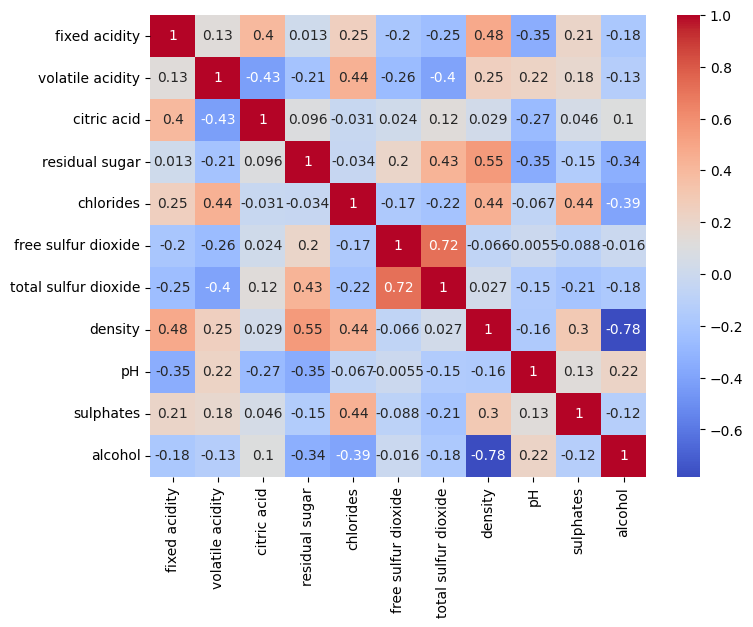

In [ ]:
correlation_matrix = X_train_smote.corr()
plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

From the correlation heatmap above, **'density' and 'alcohol'** and **'free sulfur dioxide and total sulfur dioxide'** are highly correlated which would lead to multicollinearity in our model. We will therefore determine which of the features in the two pairs have a high correlation with quality. **'density' and 'fixed acidity'** and **'density' and residual sugar'** have a moderate correlation that we would further put to consideration on how they may affect the model.



In [ ]:
correlation_quality = X_train_smote.corrwith(y_train_smote)
print(correlation_quality.sort_values(ascending = False))

alcohol                 0.566791
citric acid             0.227251
pH                      0.119290
free sulfur dioxide     0.067118
total sulfur dioxide    0.004017
residual sugar         -0.009949
sulphates              -0.066968
fixed acidity          -0.077511
volatile acidity       -0.329078
chlorides              -0.334067
density                -0.396139
dtype: float64


**'alcohol'** is highly correlated to quality compared to **'density'** despite having being close in magnitude. **'free sulfur dioxide'** has a higher correlation than **'total sulfur dioxide'**,  we will therefore keep **'free sulfur dioxide'**. Between **'density' and 'residual sugar'**, we will keep **'density'**. After the analysis, **'density', 'total sufur dioxide and 'residual sugar'** will be dropped as predictor variables.

In [ ]:
from sklearn.feature_selection import RFECV


base_estimator = RandomForestClassifier(random_state=42)

rfe = RFECV(estimator=base_estimator, step=1, cv=5, scoring='accuracy')
rfe.fit(X_train_smote, y_train_smote)

selected_features = np.array(X_train_smote.columns)[rfe.support_]
feature_ranking = rfe.ranking_

feature_ranking_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Ranking': feature_ranking,
    'Selected': rfe.support_
})

# Sort the DataFrame by ranking
feature_ranking_df.sort_values(by='Ranking', inplace=True)

# Print the DataFrame
print("Feature Ranking (1 = most important):")
print(feature_ranking_df)

Feature Ranking (1 = most important):
                 Feature  Ranking  Selected
0          fixed acidity        1      True
1       volatile acidity        1      True
2            citric acid        1      True
3         residual sugar        1      True
4              chlorides        1      True
5    free sulfur dioxide        1      True
6   total sulfur dioxide        1      True
7                density        1      True
8                     pH        1      True
9              sulphates        1      True
10               alcohol        1      True


From the different feature selection tehcniques that have been used, **'Residual sugar','Total sulfur dioxide', 'Density'** and  **'Sulphates'** have not made to the top most important features that affect the quality of wine. The features will therefore be eliminated from our predictor variables list.